In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('C:/Users/Crimson/Desktop/Neural_Net/New_Data/Merge1/all_houses1.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

In [3]:
df = df.drop(['Time'],axis =1)

In [4]:
df['Washing Machine'] = (df['Washing Machine']> 1).astype(int)
df['Dishwasher'] = (df['Dishwasher'] > 1).astype(int)
df['Television Site'] = (df['Television Site'] > 1).astype(int)
df['Microwave'] = (df['Microwave'] > 1).astype(int)
df['Kettle'] = (df['Kettle'] > 1).astype(int)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
import numpy as np

In [6]:
# setting up default plotting parameters
%matplotlib inline

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

In [7]:
print(df.Microwave.value_counts())

0    491086
1    211411
Name: Microwave, dtype: int64


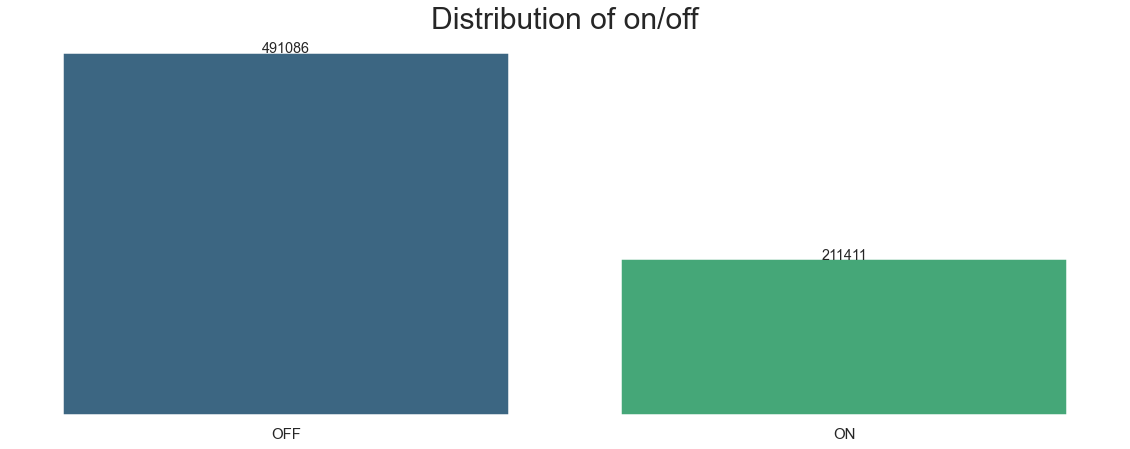

In [8]:
fig, ax = plt.subplots()
g = sns.countplot(df.Microwave, palette='viridis')
g.set_xticklabels(['OFF', 'ON'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of on/off', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

In [9]:
# print percentage of questions where target == 1
(len(df.loc[df.Microwave==1])) / (len(df.loc[df.Microwave == 0])) * 100

43.049689871020554

In [10]:
from sklearn.model_selection import train_test_split
# Separate input features and target
y = df.Microwave
X = df.drop('Microwave', axis=1)

# setting up testing and training sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20, random_state=27)

In [11]:
from sklearn.utils import resample

In [12]:
# concatenate our training data back together
X = pd.concat([train_X, train_y], axis=1)
X.head()

,Month,Weekday,Hour,Occupancy,Appliances Owned,Type,Size,Washing Machine,Dishwasher,Television Site,Kettle,Microwave
280709,4,4,1,4,23,2,3,0,0,0,0,0
544791,12,1,10,4,23,1,3,0,0,0,0,1
566618,12,1,3,4,23,3,3,1,1,0,0,0
75548,8,2,10,4,23,1,3,1,0,0,0,1
388432,5,0,2,4,23,2,3,0,0,0,0,0


In [13]:
# separate minority and majority classes
off = X[X.Microwave==0]
on = X[X.Microwave==1]

In [14]:
# upsample minority
on_upsampled = resample(on,
                          replace=True, # sample with replacement
                          n_samples=len(off), # match number in majority class
                          random_state=27) # reproducible results

In [15]:
# combine majority and upsampled minority
upsampled = pd.concat([off, on_upsampled])

In [16]:
# check new kettle counts
upsampled.Microwave.value_counts()

1    393089
0    393089
Name: Microwave, dtype: int64

In [17]:
train_y = upsampled.Microwave
train_X = upsampled.drop('Microwave', axis=1)

# ATTENTION MODEL

In [18]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [19]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [20]:
EMBED_SIZE = 1
MAX_FEATURES = 526872
RNN_CELL_SIZE = 32
MAX_LEN = 11


In [21]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

In [22]:
lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

In [23]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
context_vector, attention_weights = Attention(10)(lstm, state_h)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
  
model = tf.keras.Model(inputs=sequence_input, outputs=output)

In [24]:
# summarize layers
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 11, 1)        526872      input_1[0][0]                    
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 11, 64)       8704        embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_1 (Bidirectional)       [(None, 11, 64), (No 24832       bi_lstm_0[0][0]                  
_______________________________________________________________________________________

In [25]:
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [26]:
BATCH_SIZE = 72
EPOCHS = 100
history = model.fit(train_X,train_y,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2
                    )

Epoch 1/100
8736/8736 [==============================] - 96s 11ms/step - loss: 0.4568 - accuracy: 0.7836 - val_loss: 0.5687 - val_accuracy: 0.7062
Epoch 2/100
8736/8736 [==============================] - 94s 11ms/step - loss: 0.3862 - accuracy: 0.8207 - val_loss: 0.5031 - val_accuracy: 0.7267
Epoch 3/100
8736/8736 [==============================] - 92s 11ms/step - loss: 0.3761 - accuracy: 0.8246 - val_loss: 0.5259 - val_accuracy: 0.7181
Epoch 4/100
8736/8736 [==============================] - 94s 11ms/step - loss: 0.3722 - accuracy: 0.8257 - val_loss: 0.5186 - val_accuracy: 0.7281
Epoch 5/100
8736/8736 [==============================] - 93s 11ms/step - loss: 0.3695 - accuracy: 0.8264 - val_loss: 0.5262 - val_accuracy: 0.7396
Epoch 6/100
8736/8736 [==============================] - 93s 11ms/step - loss: 0.3673 - accuracy: 0.8272 - val_loss: 0.4935 - val_accuracy: 0.7273
Epoch 7/100
8736/8736 [==============================] - 92s 11ms/step - loss: 0.3660 - accuracy: 0.8276 - val_loss: 0

In [27]:
from matplotlib import pyplot

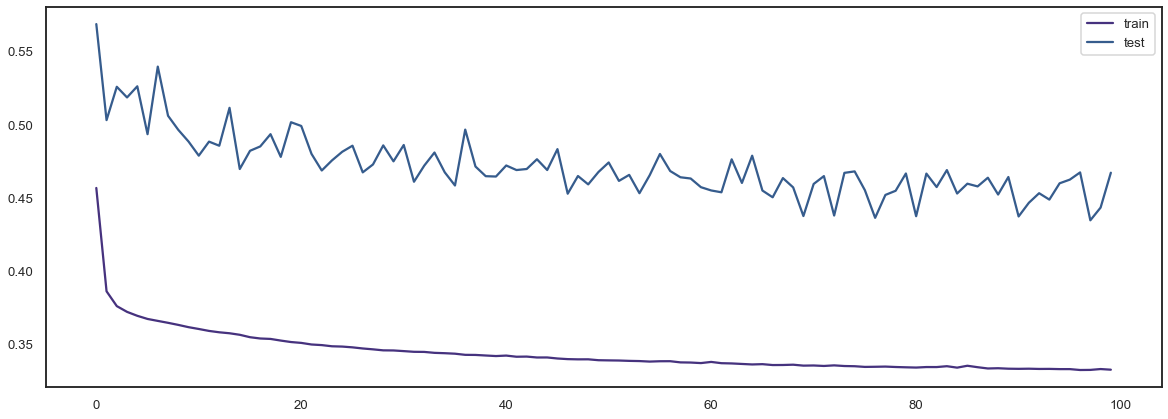

In [28]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [29]:
test_loss, test_accuracy = model.evaluate(test_X, test_y.to_numpy())

4391/4391 [==============================] - 7s 2ms/step - loss: 0.3276 - accuracy: 0.8439


In [30]:
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Accuracy: 84.39%


In [31]:
y_pred = model.predict(test_X) > 0.5

In [32]:
from sklearn.metrics import precision_score

print("Precision score: {}".format(precision_score(test_y,y_pred)))

Precision score: 0.7376912764088577


              precision    recall  f1-score   support

           0       0.89      0.88      0.89     97997
           1       0.74      0.75      0.74     42503

    accuracy                           0.84    140500
   macro avg       0.81      0.82      0.82    140500
weighted avg       0.84      0.84      0.84    140500



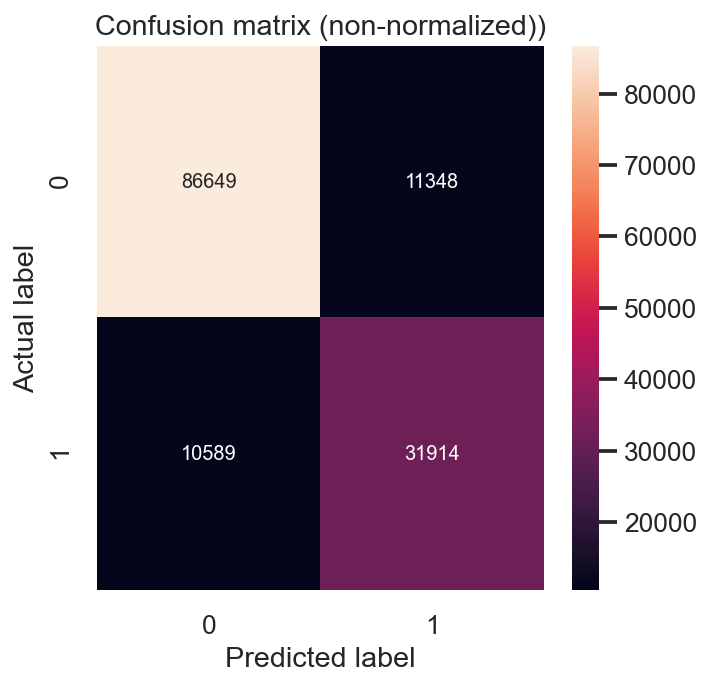

In [33]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
  
report = classification_report(test_y, y_pred)
print(report)
  
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
  
plot_cm(test_y, y_pred)

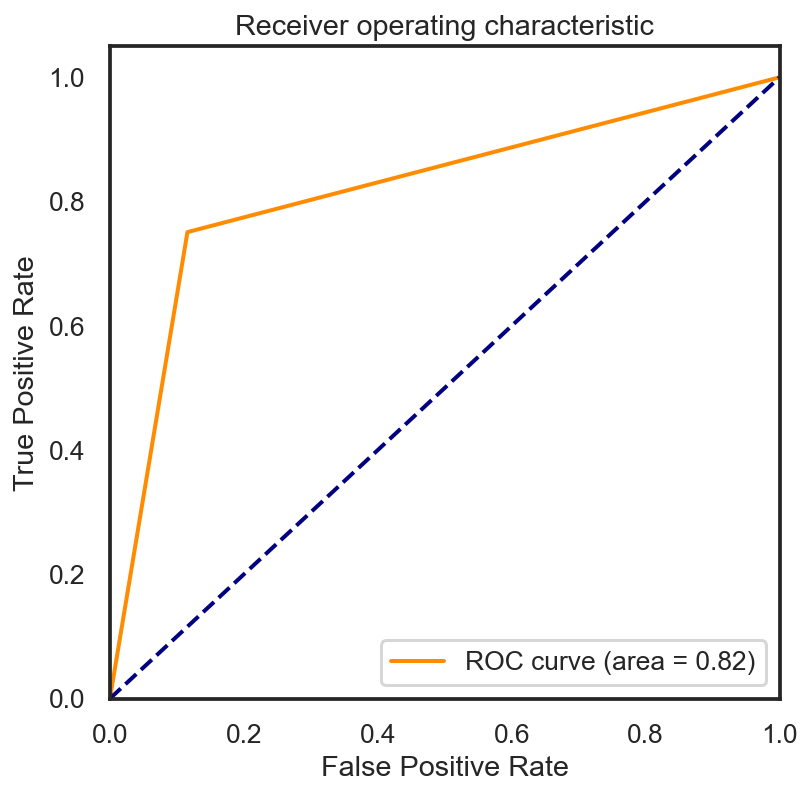

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
  
mpl.rcParams["figure.figsize"] = (6, 6)
  
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_auc_score
  
# Binarize the output
y_bin = label_binarize(test_y, classes=[0, 1])
n_classes = 1
  
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in  range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y.ravel(), y_pred.ravel())
    roc_auc[i] = auc(fpr[i], tpr[i])
  
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()